In [41]:
# You may want to install "gprof2dot"
import io
from collections import Counter

import numpy as np
import scipy.io
import sklearn.model_selection
import sklearn.tree
from numpy import genfromtxt
from scipy import stats
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import graphviz
from graphviz import Digraph

import pydot

In [42]:
eps = 1e-5  # a small number


class DecisionTree:
    def __init__(self, max_depth=3, feature_labels=None):
        self.max_depth = max_depth
        self.features = feature_labels
        self.left, self.right = None, None  # for non-leaf nodes
        self.split_idx, self.thresh = None, None  # for non-leaf nodes
        self.data, self.pred = None, None  # for leaf nodes

    @staticmethod
    def information_gain(X, y, thresh):
        # TODO: implement information gain function
        parent_entropy = DecisionTree.entropy(y)
        idx0 = np.where(X < thresh)[0]
        idx1 = np.where(X >= thresh)[0]
        if len(idx0) == 0 or len(idx1) == 0:
            return 0
        left_entropy = DecisionTree.entropy(y[idx0])
        right_entropy = DecisionTree.entropy(y[idx1])
        Hafter_entropy = (len(idx0) * left_entropy + len(idx1) * right_entropy) / (len(idx0) + len(idx1))
        return (parent_entropy - Hafter_entropy)
    
    @staticmethod
    def entropy(labels):
        unique, num_per_label = np.unique(labels, return_counts=True)
        probabilities = [x / len(labels) for x in num_per_label]
        entropy = 0
        for prob in probabilities:
            entropy = entropy - prob * np.log2(prob)
        return entropy


    @staticmethod
    def gini_impurity(X, y, thresh):
        # TODO: implement gini impurity function
        pass

    def split(self, X, y, idx, thresh):
        X0, idx0, X1, idx1 = self.split_test(X, idx=idx, thresh=thresh)
        y0, y1 = y[idx0], y[idx1]
        return X0, y0, X1, y1

    def split_test(self, X, idx, thresh):
        idx0 = np.where(X[:, idx] < thresh)[0]
        idx1 = np.where(X[:, idx] >= thresh)[0]
        X0, X1 = X[idx0, :], X[idx1, :]
        return X0, idx0, X1, idx1

    def fit(self, X, y):
        if self.max_depth > 0:
            # compute entropy gain for all single-dimension splits,
            # thresholding with a linear interpolation of 10 values
            gains = []
            # The following logic prevents thresholding on exactly the minimum
            # or maximum values, which may not lead to any meaningful node
            # splits.
            thresh = np.array([
                np.linspace(np.min(X[:, i]) + eps, np.max(X[:, i]) - eps, num=10)
                for i in range(X.shape[1])
            ])
            for i in range(X.shape[1]):
                gains.append([self.information_gain(X[:, i], y, t) for t in thresh[i, :]])

            gains = np.nan_to_num(np.array(gains))
            self.split_idx, thresh_idx = np.unravel_index(np.argmax(gains), gains.shape)
            self.thresh = thresh[self.split_idx, thresh_idx]
            X0, y0, X1, y1 = self.split(X, y, idx=self.split_idx, thresh=self.thresh)
            if X0.size > 0 and X1.size > 0:
                self.left = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.left.fit(X0, y0)
                self.right = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.right.fit(X1, y1)
            else:
                self.max_depth = 0
                self.data, self.labels = X, y
                self.pred = stats.mode(y).mode[0]
        else:
            self.data, self.labels = X, y
            self.pred = stats.mode(y).mode[0]
        return self
    
    def fit_random_forest(self, X, y, m):
        if self.max_depth > 0:
            # randomly select m features out of d total features
            np.random.seed(self.max_depth)
            feature_indices = np.random.choice(X.shape[1], m, replace=False)
            X_rand = X[:, feature_indices]

            # compute entropy gain for all single-dimension splits for the selected features
            gains = []
            thresh = np.array([
                np.linspace(np.min(X_rand[:, i]) + eps, np.max(X_rand[:, i]) - eps, num=10)
                for i in range(X_rand.shape[1])
            ])
            for i in range(X_rand.shape[1]):
                gains.append([self.information_gain(X_rand[:, i], y, t) for t in thresh[i, :]])

            gains = np.nan_to_num(np.array(gains))
            split_idx, thresh_idx = np.unravel_index(np.argmax(gains), gains.shape)
            self.split_idx = feature_indices[split_idx]
            self.thresh = thresh[split_idx, thresh_idx]
            X0, y0, X1, y1 = self.split(X, y, idx=self.split_idx, thresh=self.thresh)
            if X0.size > 0 and X1.size > 0:
                self.left = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.left.fit_random_forest(X0, y0, m)
                self.right = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.right.fit_random_forest(X1, y1, m)
            else:
                self.max_depth = 0
                self.data, self.labels = X, y
                self.pred = stats.mode(y).mode[0]
        else:
            self.data, self.labels = X, y
            self.pred = stats.mode(y).mode[0]
        return self

    def predict(self, X):
        if self.max_depth == 0:
            return self.pred * np.ones(X.shape[0])
        else:
            X0, idx0, X1, idx1 = self.split_test(X, idx=self.split_idx, thresh=self.thresh)
            yhat = np.zeros(X.shape[0])
            yhat[idx0] = self.left.predict(X0)
            yhat[idx1] = self.right.predict(X1)
            return yhat

    def __repr__(self):
        if self.max_depth == 0:
            return "%s (%s)" % (self.pred, self.labels.size)
        else:
            return "[%s < %s: %s | %s]" % (self.features[self.split_idx],
                                           self.thresh, self.left.__repr__(),
                                           self.right.__repr__())
    
    def visualize(self, dot=None, parent=None, is_left=True):
        if dot is None:
            dot = Digraph()
        if self.left is None and self.right is None:  # leaf node
            dot.node(str(id(self)), label=f"class={self.pred}")
            if parent is not None:
                dot.edge(str(id(parent)), str(id(self)), label="yes" if is_left else "no")
        else:  # non-leaf node
            node_label = f"{self.features[self.split_idx]} < {self.thresh:.5f}?"
            dot.node(str(id(self)), label=node_label)
            if parent is not None:
                dot.edge(str(id(parent)), str(id(self)), label="yes" if is_left else "no")
            self.left.visualize(dot=dot, parent=self, is_left=True)
            self.right.visualize(dot=dot, parent=self, is_left=False)
        return dot

class BaggedTrees(BaseEstimator, ClassifierMixin):
    def __init__(self, params=None, n=200, max_depth=3):
        if params is None:
            params = {}
        self.params = params
        self.n = n
        self.random_seed = 0
        self.max_depth = max_depth
        self.decision_trees = [
            sklearn.tree.DecisionTreeClassifier(random_state=i, **self.params)
            for i in range(self.n)
        ]
        self.non_sklearn_trees = []

    def fit(self, X, y):
        for i in range(self.n):
            self.non_sklearn_trees.append(DecisionTree(max_depth=self.max_depth))
            new_labels = []
            new_datapoints = []
            for _ in range(len(y)):
                np.random.seed(self.random_seed)
                num = np.random.randint(0, len(y) - 1)
                self.random_seed = self.random_seed + 1
                new_datapoints.append(X[num])
                new_labels.append(y[num])
            self.non_sklearn_trees[i].fit(np.array(new_datapoints), np.array(new_labels))
                

    def predict(self, X):
        answers = []
        predictions = []
        for tree in self.non_sklearn_trees:
            answers.append(tree.predict(X))
        answer_arr = np.array(answers)
        final_array = np.vstack(answer_arr)
        final_array = final_array.T
        for i in range(final_array.shape[0]):
            unique_values, counts = np.unique(final_array[i], return_counts=True)
            mode = unique_values[np.argmax(counts)]
            predictions.append(mode)
        return predictions
        

class RandomForest(BaggedTrees):
    def __init__(self, params=None, n=200, m=1, max_depth=3, combo=False, deep=0, shallow=0):
        if params is None:
            params = {}
        self.num_feats = m
        self.num_trees = n 
        self.random_seed = 0
        self.non_sklearn_trees = []
        self.depth = max_depth
        self.combo = combo
        self.deep = deep
        self.shallow = shallow
        self.deeptrees = []
        self.shallowtrees = []
        self.finalpreds= []
    
    def fit(self, X, y):
        if not self.combo:
            for i in range(self.num_trees):
                self.non_sklearn_trees.append(DecisionTree(max_depth=self.depth))
                new_labels = []
                new_datapoints = []
                for _ in range(len(y)):
                    np.random.seed(self.random_seed)
                    num = np.random.randint(0, len(y) - 1)
                    self.random_seed = self.random_seed + 1
                    new_datapoints.append(X[num])
                    new_labels.append(y[num])
                self.non_sklearn_trees[i].fit_random_forest(np.array(new_datapoints), np.array(new_labels), self.num_feats)
        else:
            for i in range(self.num_trees):
                self.deeptrees.append(DecisionTree(max_depth=self.deep))
                new_labels = []
                new_datapoints = []

                for _ in range(len(y)):
                    np.random.seed(self.random_seed)
                    num = np.random.randint(0, len(y) - 1)
                    self.random_seed = self.random_seed + 1
                    new_datapoints.append(X[num])
                    new_labels.append(y[num])
                self.deeptrees[i].fit_random_forest(np.array(new_datapoints), np.array(new_labels), self.num_feats)

                self.shallowtrees.append(DecisionTree(max_depth=self.shallow))
                new_labels = []
                new_datapoints = []
                for _ in range(len(y)):
                    np.random.seed(self.random_seed)
                    num = np.random.randint(0, len(y) - 1)
                    self.random_seed = self.random_seed + 1
                    new_datapoints.append(X[num])
                    new_labels.append(y[num])
                self.shallowtrees[i].fit_random_forest(np.array(new_datapoints), np.array(new_labels), self.num_feats)
    
    def predict(self, X):
        if self.combo:
            answers = []
            predictions = []
            for tree in self.deeptrees:
                answers.append(tree.predict(X))
            for tree in self.shallowtrees:
                answers.append(tree.predict(X))
            answer_arr = np.array(answers)
            final_array = np.vstack(answer_arr)
            final_array = final_array.T
            for i in range(final_array.shape[0]):
                unique_values, counts = np.unique(final_array[i], return_counts=True)
                mode = unique_values[np.argmax(counts)]
                predictions.append(mode)
            return predictions
        else:
            answers = []
            predictions = []
            for tree in self.non_sklearn_trees:
                answers.append(tree.predict(X))
            answer_arr = np.array(answers)
            final_array = np.vstack(answer_arr)
            final_array = final_array.T
            for i in range(final_array.shape[0]):
                unique_values, counts = np.unique(final_array[i], return_counts=True)
                mode = unique_values[np.argmax(counts)]
                predictions.append(mode)
            return predictions

    


class BoostedRandomForest(RandomForest):
    def fit(self, X, y):
        self.w = np.ones(X.shape[0]) / X.shape[0]  # Weights on data
        self.a = np.zeros(self.n)  # Weights on decision trees
        # TODO: implement function
        return self

    def predict(self, X):
        # TODO: implement function
        pass


def preprocess(data, fill_mode=True, min_freq=10, onehot_cols=[]):
    # fill_mode = False

    # Temporarily assign -1 to missing data
    data[data == ''] = '-1'

    # Hash the columns (used for handling strings)
    onehot_encoding = []
    onehot_features = []
    for col in onehot_cols:
        counter = Counter(data[:, col])
        for term in counter.most_common():
            if term[0] == '-1':
                continue
            if term[-1] <= min_freq:
                break
            onehot_features.append(term[0])
            onehot_encoding.append((data[:, col] == term[0]).astype(float))
        data[:, col] = '0'
    onehot_encoding = np.array(onehot_encoding).T
    data = np.hstack([np.array(data, dtype=float), np.array(onehot_encoding)])

    # Replace missing data with the mode value. We use the mode instead of
    # the mean or median because this makes more sense for categorical
    # features such as gender or cabin type, which are not ordered.
    if fill_mode:
        for i in range(data.shape[-1]):
            mode = stats.mode(data[((data[:, i] < -1 - eps) +
                                    (data[:, i] > -1 + eps))][:, i]).mode[0]
            data[(data[:, i] > -1 - eps) * (data[:, i] < -1 + eps)][:, i] = mode

    return data, onehot_features


In [43]:
if __name__ == "__main__":

    # Load titanic data
    path_train = '/Users/Dom/Desktop/CS189/hw5/hw5_code/dataset/titanic/titanic_training.csv'
    data_titianic = genfromtxt(path_train, delimiter=',', dtype=None, encoding=None)
    path_test = '/Users/Dom/Desktop/CS189/hw5/hw5_code/dataset/titanic/titanic_test_data.csv'
    test_data_titianic = genfromtxt(path_test, delimiter=',', dtype=None, encoding=None)
    y = data_titianic[1:, -1]  # label = survived
    class_names = ["Died", "Survived"]
    labeled_idx = np.where(y != '')[0]

    y = np.array(y[labeled_idx])
    y = y.astype(float).astype(int)


    # print("\n\nPart (b): preprocessing the titanic dataset")
    X, onehot_features = preprocess(data_titianic[1:, :-1], onehot_cols=[1, 5, 7, 8])
    X = X[labeled_idx, :]
    Z_titanic, _ = preprocess(test_data_titianic[1:, :], onehot_cols=[1, 5, 7, 8])
    assert X.shape[1] == Z_titanic.shape[1]
    features = list(data_titianic[0, :-1]) + onehot_features

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=14)

    dt_titanic = DecisionTree(max_depth=5, feature_labels=features)
    dt_titanic.fit(X_train, y_train)
    dt_pred_train = dt_titanic.predict(X_train)
    dt_pred_val = dt_titanic.predict(X_val)

    train_correct = 0
    validation_correct = 0

    for i in range(len(dt_pred_train)):
        if y_train[i] == dt_pred_train[i]:
            train_correct = train_correct + 1

    for i in range(len(dt_pred_val)):
        if y_val[i] == dt_pred_val[i]:
            validation_correct = validation_correct + 1

    print("Decision Tree training accuracy Titanic = " + str(train_correct/len(dt_pred_train)))
    print("Decision Tree validation accuracy Titanic = " + str(validation_correct/len(dt_pred_val)))

    rf_titanic = RandomForest(n = 125, m = int(X.shape[1]/4*3), max_depth=6, combo=False, shallow=3, deep=7)
    rf_titanic.fit(X_train, y_train)
    rf_pred_train = rf_titanic.predict(X_train)
    rf_pred_val = rf_titanic.predict(X_val)

    train_correct = 0
    validation_correct = 0

    for i in range(len(rf_pred_train)):
        if y_train[i] == rf_pred_train[i]:
            train_correct = train_correct + 1

    for i in range(len(rf_pred_val)):
        if y_val[i] == rf_pred_val[i]:
            validation_correct = validation_correct + 1

    print("Random Forest training accuracy Titanic = " + str(train_correct/len(rf_pred_train)))
    print("Random Forest validation accuracy Titanic = " + str(validation_correct/len(rf_pred_val)))

    features = [
        "pain", "private", "bank", "money", "drug", "spam", "prescription", "creative",
        "height", "featured", "differ", "width", "other", "energy", "business", "message",
        "volumes", "revision", "path", "meter", "memo", "planning", "pleased", "record", "out",
        "semicolon", "dollar", "sharp", "exclamation", "parenthesis", "square_bracket",
        "ampersand"
    ]

    assert len(features) == 32

    # Load spam data
    path_train = '/Users/Dom/Desktop/CS189/hw5/hw5_code/dataset/spam/spam_data.mat'
    data_spam = scipy.io.loadmat(path_train)
    X = data_spam['training_data']
    y = np.squeeze(data_spam['training_labels'])
    Z_spam = data_spam['test_data']
    class_names = ["Ham", "Spam"]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=14)

    dt_spam = DecisionTree(max_depth=10, feature_labels=features)
    dt_spam.fit(X_train, y_train)
    dt_pred_train = dt_spam.predict(X_train)
    dt_pred_val = dt_spam.predict(X_val)

    train_correct = 0
    validation_correct = 0

    for i in range(len(dt_pred_train)):
        if y_train[i] == dt_pred_train[i]:
            train_correct = train_correct + 1

    for i in range(len(dt_pred_val)):
        if y_val[i] == dt_pred_val[i]:
            validation_correct = validation_correct + 1

    print("Decision Tree training accuracy Spam = " + str(train_correct/len(dt_pred_train)))
    print("Decision Tree validation accuracy Spam = " + str(validation_correct/len(dt_pred_val)))

    rf_spam = RandomForest(n = 75, m = int(np.sqrt(X.shape[1])), max_depth=8)
    rf_spam.fit(X_train, y_train)
    rf_pred_train = rf_spam.predict(X_train)
    rf_pred_val = rf_spam.predict(X_val)

    train_correct = 0
    validation_correct = 0

    for i in range(len(rf_pred_train)):
        if y_train[i] == rf_pred_train[i]:
            train_correct = train_correct + 1

    for i in range(len(rf_pred_val)):
        if y_val[i] == rf_pred_val[i]:
            validation_correct = validation_correct + 1

    print("Random Forest training accuracy Spam = " + str(train_correct/len(rf_pred_train)))
    print("Random Forest validation accuracy Spam = " + str(validation_correct/len(rf_pred_val)))

/var/folders/64/n8j38dh55w9g5jp6yj7zqzm40000gn/T/ipykernel_25807/534022120.py:326: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(data[((data[:, i] < -1 - eps) +
/var/folders/64/n8j38dh55w9g5jp6yj7zqzm40000gn/T/ipykernel_25807/534022120.py:80: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

Decision Tree training accuracy Titanic = 0.8197747183979975
Decision Tree validation accuracy Titanic = 0.8


/var/folders/64/n8j38dh55w9g5jp6yj7zqzm40000gn/T/ipykernel_25807/534022120.py:120: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self.pred = stats.mode(y).mode[0]
/var/folders/64/n8j38dh55w9g5jp6yj7zqzm40000gn/T/ipykernel_25807/534022120.py:117: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or Fal

Random Forest training accuracy Titanic = 0.8448060075093867
Random Forest validation accuracy Titanic = 0.82
Decision Tree training accuracy Spam = 0.8584280303030303
Decision Tree validation accuracy Spam = 0.8125
Random Forest training accuracy Spam = 0.8404356060606061
Random Forest validation accuracy Spam = 0.8087121212121212


In [44]:
def results_to_csv_titanic(y_test):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1 # Ensures that the index starts at 1
    df.to_csv('titanic_submission.csv', index_label='Id')

def results_to_csv_spam(y_test):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1 # Ensures that the index starts at 1
    df.to_csv('spam_submission.csv', index_label='Id')
    
Kaggle_titanic_pre = rf_titanic.predict(Z_titanic) 
Kaggle_spam_pre = rf_spam.predict(Z_spam)

Kaggle_titanic = np.array([int(np.round(x)) for x in Kaggle_titanic_pre])
Kaggle_spam = np.array([int(np.round(x)) for x in Kaggle_spam_pre])
results_to_csv_titanic(Kaggle_titanic)
results_to_csv_spam(Kaggle_spam)


/var/folders/64/n8j38dh55w9g5jp6yj7zqzm40000gn/T/ipykernel_25807/534022120.py:83: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self.pred = stats.mode(y).mode[0]
/var/folders/64/n8j38dh55w9g5jp6yj7zqzm40000gn/T/ipykernel_25807/534022120.py:80: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False

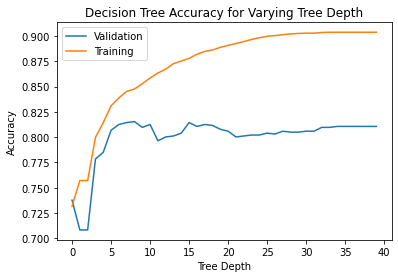

In [45]:
features = [
        "pain", "private", "bank", "money", "drug", "spam", "prescription", "creative",
        "height", "featured", "differ", "width", "other", "energy", "business", "message",
        "volumes", "revision", "path", "meter", "memo", "planning", "pleased", "record", "out",
        "semicolon", "dollar", "sharp", "exclamation", "parenthesis", "square_bracket",
        "ampersand"
    ]
assert len(features) == 32

# Load spam data
path_train = '/Users/Dom/Desktop/CS189/hw5/hw5_code/dataset/spam/spam_data.mat'
data = scipy.io.loadmat(path_train)
X = data['training_data']
y = np.squeeze(data['training_labels'])
Z = data['test_data']
class_names = ["Ham", "Spam"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=14)


indexes = []
validation_accuracies = []
training_accuracies = []
for i in range(40):
    indexes.append(i)
    dt = DecisionTree(max_depth=i, feature_labels=features)
    dt.fit(X_train, y_train)
    dt_pred_train = dt.predict(X_train)
    dt_pred_val = dt.predict(X_val)

    train_correct = 0
    validation_correct = 0

    for i in range(len(dt_pred_train)):
        if y_train[i] == dt_pred_train[i]:
            train_correct = train_correct + 1

    for i in range(len(dt_pred_val)):
        if y_val[i] == dt_pred_val[i]:
            validation_correct = validation_correct + 1

    training_accuracies.append(train_correct/len(dt_pred_train))
    validation_accuracies.append(validation_correct/len(dt_pred_val))
    
plt.plot(indexes, validation_accuracies, label = "Validation") 
plt.plot(indexes, training_accuracies, label = "Training") 
plt.xlabel("Tree Depth") 
plt.ylabel("Accuracy") 
plt.title("Decision Tree Accuracy for Varying Tree Depth")
plt.legend()
plt.show()

/var/folders/64/n8j38dh55w9g5jp6yj7zqzm40000gn/T/ipykernel_25807/534022120.py:326: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(data[((data[:, i] < -1 - eps) +
/var/folders/64/n8j38dh55w9g5jp6yj7zqzm40000gn/T/ipykernel_25807/534022120.py:83: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

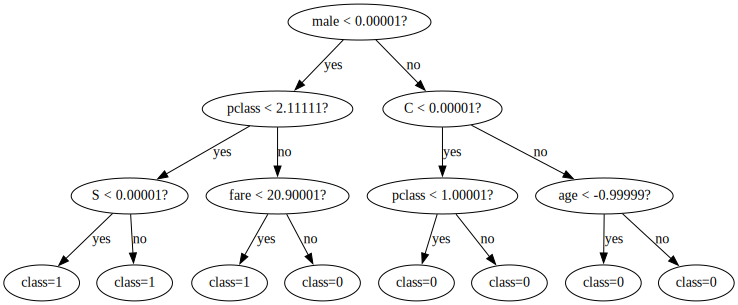

In [46]:
# Load titanic data
path_train = '/Users/Dom/Desktop/CS189/hw5/hw5_code/dataset/titanic/titanic_training.csv'
data_titianic = genfromtxt(path_train, delimiter=',', dtype=None, encoding=None)
path_test = '/Users/Dom/Desktop/CS189/hw5/hw5_code/dataset/titanic/titanic_test_data.csv'
test_data_titianic = genfromtxt(path_test, delimiter=',', dtype=None, encoding=None)
y = data_titianic[1:, -1]  # label = survived
class_names = ["Died", "Survived"]
labeled_idx = np.where(y != '')[0]

y = np.array(y[labeled_idx])
y = y.astype(float).astype(int)


# print("\n\nPart (b): preprocessing the titanic dataset")
X, onehot_features = preprocess(data_titianic[1:, :-1], onehot_cols=[1, 5, 7, 8])
X = X[labeled_idx, :]
Z_titanic, _ = preprocess(test_data_titianic[1:, :], onehot_cols=[1, 5, 7, 8])
assert X.shape[1] == Z_titanic.shape[1]
features = list(data_titianic[0, :-1]) + onehot_features

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=14)

dt_titanic = DecisionTree(max_depth=3, feature_labels=features)
dt_titanic.fit(X_train, y_train)
dt_titanic.visualize()




/var/folders/64/n8j38dh55w9g5jp6yj7zqzm40000gn/T/ipykernel_25807/534022120.py:83: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self.pred = stats.mode(y).mode[0]
/var/folders/64/n8j38dh55w9g5jp6yj7zqzm40000gn/T/ipykernel_25807/534022120.py:80: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False

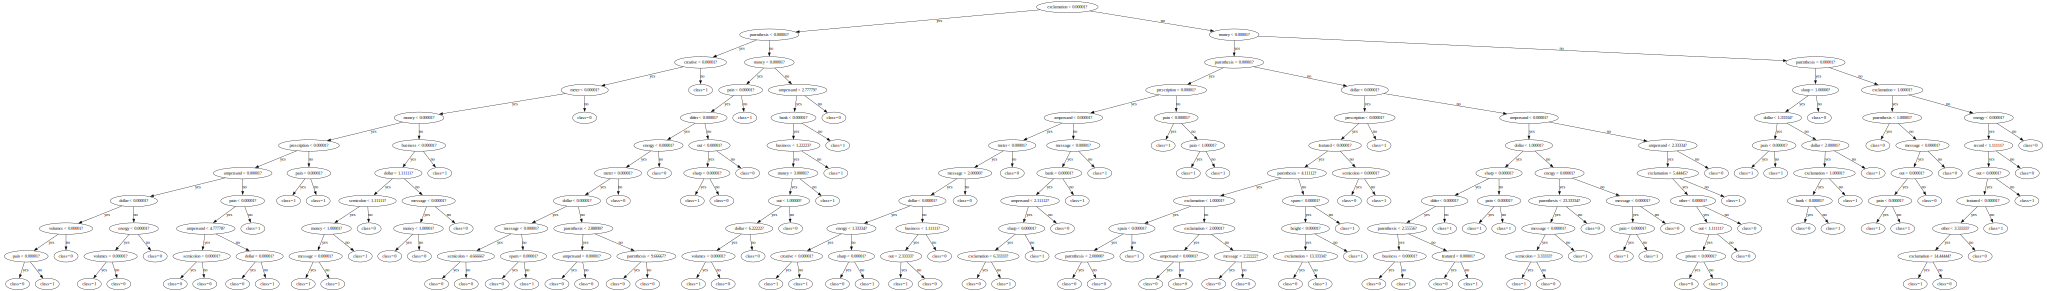

In [47]:
features = [
        "pain", "private", "bank", "money", "drug", "spam", "prescription", "creative",
        "height", "featured", "differ", "width", "other", "energy", "business", "message",
        "volumes", "revision", "path", "meter", "memo", "planning", "pleased", "record", "out",
        "semicolon", "dollar", "sharp", "exclamation", "parenthesis", "square_bracket",
        "ampersand"
    ]

assert len(features) == 32

# Load spam data
path_train = '/Users/Dom/Desktop/CS189/hw5/hw5_code/dataset/spam/spam_data.mat'
data_spam = scipy.io.loadmat(path_train)
X = data_spam['training_data']
y = np.squeeze(data_spam['training_labels'])
Z_spam = data_spam['test_data']
class_names = ["Ham", "Spam"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=14)

dt_spam = DecisionTree(max_depth=10, feature_labels=features)
dt_spam.fit(X_train, y_train)
dt_spam.visualize()

In [48]:
FEATURES = [
        "pain", "private", "bank", "money", "drug", "spam", "prescription", "creative",
        "height", "featured", "differ", "width", "other", "energy", "business", "message",
        "volumes", "revision", "path", "meter", "memo", "planning", "pleased", "record", "out",
        "semicolon", "dollar", "sharp", "exclamation", "parenthesis", "square_bracket",
        "ampersand"
    ]

assert len(FEATURES) == 32

# Load spam data
path_train = '/Users/Dom/Desktop/CS189/hw5/hw5_code/dataset/spam/spam_data.mat'
data_spam = scipy.io.loadmat(path_train)
TRAINING_SPAM = data_spam['training_data']
LABELS_SPAM = np.squeeze(data_spam['training_labels'])
Z_spam = data_spam['test_data']
class_names = ["Ham", "Spam"]

(1) Spam:
exclamation >= 0.00001
money < 0.00001
parenthesis < 0.00001
prescription >= 0.00001
pain < 0.00001

Therefore Spam

(0) Ham:
exclamation >= 0.00001
money < 0.00001
parenthesis >= 0.00001
dollar < 0.00001
prescription < 0.00001
featured < 0.00001
parenthesis < 4.11112
exclamation >= 1.00001
exclamation >= 2.00001
message < 2.22222

Therefore Ham